## Intermittant demand tests

In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import pandas as pd

Demand generator

In [2]:
def intermittant_demand_generator(size,lower_bound,burst_frequency) :
    demands = np.zeros(size)

    burst_period = np.random.randint(burst_frequency)
    while(burst_period < size) :
        demands[burst_period] = lower_bound + scipy.stats.uniform().rvs()
        burst_period += 1+np.random.randint(burst_frequency)

    return demands

Parameters of the simulation : $T,\tau,\underline{y},\overline{y},\underline{d}, y_1, \gamma, L$

In [8]:
T = 100_000
tau = 2
y_lb = 1
y_ub = 2
d_lb = 1
y_1 = (y_ub+y_lb)/2
gamma = 1/(y_ub-y_lb) # <= 1/(y_ub-y_lb) #1/2
assert gamma <= 1/(y_ub-y_lb), "gamma is too big"
L = 1

Demand generation

(0.0, 3.0)

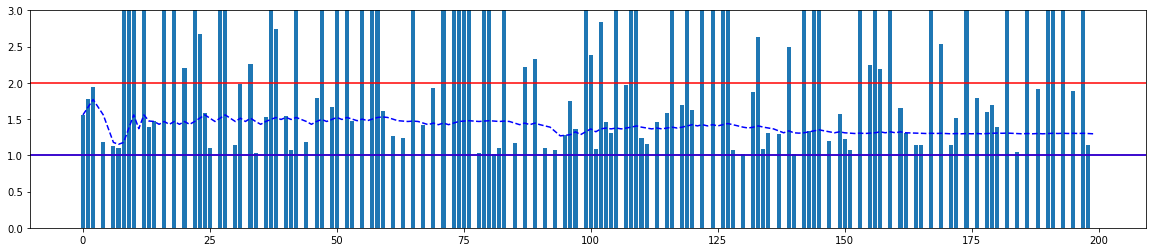

In [9]:
demands = np.array(pd.read_csv("demand_series/demands_1.csv",index_col=0)).T[0,0:T]
#demands = intermittant_demand_generator(T,d_lb,tau)
#demands = 1+scipy.stats.lognorm(s=0.5).rvs(size=T)
past_demands_median = np.array(pd.Series(demands).expanding().median())

plt.figure(figsize=(20,4))
plt.bar(np.arange(200),demands[:200])

plt.axhline(y_lb,color="red")
plt.axhline(d_lb,color="blue")
plt.axhline(y_ub,color="red")
plt.plot(past_demands_median[:200],color="blue",linestyle="--")
plt.ylim((0,y_lb+y_ub))

import os
pd.Series(demands).to_csv(os.path.join("demand_series","demands_1"))

Algorithm

In [10]:
xt = 0
yt = y_1
k = 1
st = 0
s_min = y_ub
tau_max = 1
Yk = y_1
last_non_zero_period = 1
G = 0

sales = np.zeros(T)
gradients = np.zeros(T)
losses = np.zeros(T)
stock_levels = np.zeros(T)
initial_inventories = np.zeros(T)

for t in np.arange(1,T+1) :
    initial_inventories[t-1] = xt
    
    if(st>0) :
        s_min = min(s_min,st)
        tau_max = max(tau_max, t-last_non_zero_period)
        eta = gamma*s_min*(y_ub-y_lb)/(tau_max*L*np.sqrt(k))

        #assert G == L*(t-last_non_zero_period-1)+gt, "weird"
        Yk = np.clip(   
            Yk - eta*G,
            y_lb,
            y_ub
        )

        last_non_zero_period = t
        k=k+1
        G = 0
    

    yt = Yk
    assert yt >= xt, "Negative order error"

    dt = demands[t-1]
    st = min(yt,dt)
    gt = L if yt > dt else -L
    lt = np.abs(yt-dt)
    G += gt
    xt = yt-st

    sales[t-1] = st
    gradients[t-1] = gt
    losses[t-1] = lt
    stock_levels[t-1] = yt

Regret

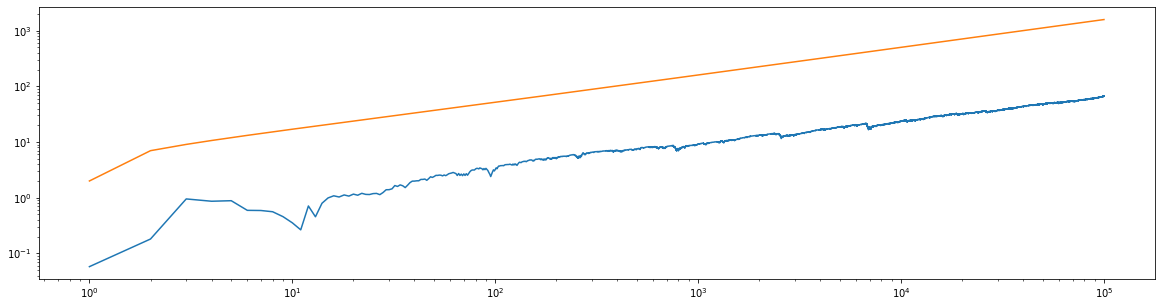

Final regret 66.54788882105294


In [14]:
regrets = np.cumsum(losses-np.abs(demands-past_demands_median))
regret_upper_bound = tau*L*(y_ub-y_lb)*((1/(2*gamma*min(y_lb,d_lb))+gamma*y_ub)*np.sqrt(np.arange(T))+1)

plt.figure(figsize=(20,5))
plt.loglog(np.arange(1,T+1), np.cumsum(losses-np.abs(demands-past_demands_median)))
plt.loglog(np.arange(1,T+1),regret_upper_bound)
plt.show()
print("Final regret {}".format(regrets[-1]))

(0.0, 3.0)

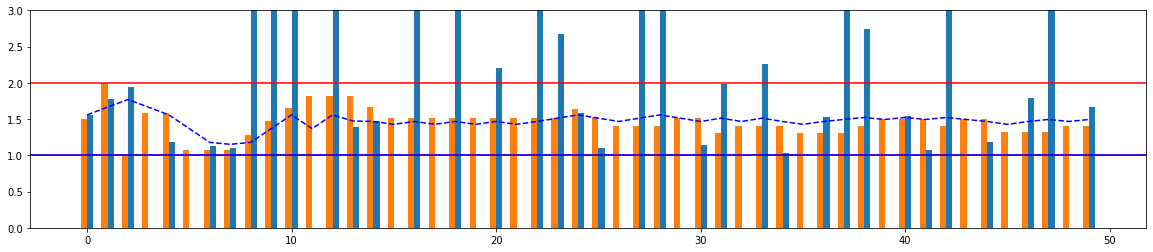

In [12]:
starting_period = 0
ending_period = 50

plt.figure(figsize=(20,4))
plt.bar(np.arange(starting_period,ending_period)+0.15,demands[starting_period:ending_period],width=0.3)
plt.plot(np.arange(starting_period,ending_period), past_demands_median[starting_period:ending_period],color="blue",linestyle="--")
plt.bar(np.arange(starting_period,ending_period)-0.15, stock_levels[starting_period:ending_period],width=0.3)

plt.axhline(y_lb,color="red")
plt.axhline(d_lb,color="blue")
plt.axhline(y_ub,color="red")
plt.ylim((0,y_ub+y_lb))


---

In [77]:
data = intermittant_demand_generator(size,1,3)
max_zero_interval_length = 1
last_zero_interval_length = 1
for i in data :
    if(i == 0) :
        last_zero_interval_length += 1
    else :
        max_zero_interval_length = np.maximum(max_zero_interval_length,last_zero_interval_length)
        last_zero_interval_length = 1
print(max_zero_interval_length)
print(data)

NameError: name 'size' is not defined